<h1 align="center"> Mall Customers: Clustering </h1>

<img src="https://gd-disneyeorlando.sfo2.cdn.digitaloceanspaces.com/2016/02/shopping-altamonte-mall-em-orlando.jpg" width="50%" />

Created: 2020-09-04

Last updated: 2020-09-19

Kaggle Kernel made by 🚀 <a href="https://www.kaggle.com/rafanthx13"> Rafael Morais de Assis</a>


## Problem Description

DataSet Link: https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python

**Content**

You are owing a supermarket mall and through membership cards , you have some basic data about your customers like Customer ID, age, gender, annual income and spending score.
Spending Score is something you assign to the customer based on your defined parameters like customer behavior and purchasing data.

**Problem Statement**

You own the mall and want to understand the customers like who can be easily converge [Target Customers] so that the sense can be given to marketing team and plan the strategy accordingly.

**Inspiration**

By the end of this case study , you would be able to answer below questions.
1. How to achieve customer segmentation using machine learning algorithm (KMeans Clustering) in Python in simplest way.
2. Who are your target customers with whom you can start marketing strategy [easy to converse]
3. How the marketing strategy works in real world

## DataSet Description


| Column         | Description                                                                   | Values                           |
|----------------|-------------------------------------------------------------------------------|----------------------------------|
| Gender         | Gender of the customer                                                        | string :: 'Male' <br>or 'Female' |
| Age            | Age of the customer                                                           | int :: [18, 70]                  |
| Annual Income  | Annual Income of the customer.<br> Measure in k$                              | int :: [15, 137]                 |
| Spending Score | Score assigned by the mall based <br>on customer behavior and spending nature | int :: [1, 99]                   |

## Table Of Contents (TOC) <a id="top"></a>

+ [Import Libs and DataSet](#index01) 
+ [Snippets](#index02)
+ [Feature engineering](#index03)
+ [EDA](#index04)
  - [Each feature individually](#index04)
  - [Cross two features](#index05)
  - [Cross all features](#index06)
+ [Pre-Processing](#index07)
+ [Clustering with K-Means](#index08)
  - [Best K with elbow method](#index09)
  - [Execute KMeans](#index10)
  - [Groups Interpreting](#index11)
+ [Clustering by pycaret](#index13)
+ [Conclusion](#index12)

## Import Libs and DataSet <a id='index01'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import time
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Configs
pd.options.display.float_format = '{:,.3f}'.format
sns.set(style="whitegrid")
plt.style.use('seaborn')
seed = 42
np.random.seed(seed)

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


In [2]:
file_path = '/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv'
df = pd.read_csv(file_path)

print("DataSet = {} rows and {} columns".format(df.shape[0], df.shape[1]))

quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
qualitative = [f for f in df.columns if df.dtypes[f] == 'object']

print("\nQualitative Variables: (Numerics)", "\n=>", quantitative,
      "\n\nQuantitative Variable: (Strings)\n=>", qualitative )

df.head()

DataSet = 200 rows and 5 columns

Qualitative Variables: (Numerics) 
=> ['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'] 

Quantitative Variable: (Strings)
=> ['Gender']


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# No Missing Data
df.isnull().sum().max()

0

In [4]:
# Restructure DataFrame
dict_rename = {'Gender': 'gender', 'Age': 'age', 'Annual Income (k$)': 'income', 'Spending Score (1-100)': 'spending_score'}
df = df.rename(dict_rename, axis=1).drop(['CustomerID'], axis =1)
df.describe()

,age,income,spending_score
count,200.000,200.000,200.000
mean,38.850,60.560,50.200
std,13.969,26.265,25.824
min,18.000,15.000,1.000
25%,28.750,41.500,34.750
50%,36.000,61.500,50.000
75%,49.000,78.000,73.000
max,70.000,137.000,99.000


## Snippets <a id='index02'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

In [5]:
def eda_categ_feat_desc_plot(series_categorical, title = ""):
    series_name = series_categorical.name
    val_counts = series_categorical.value_counts()
    val_counts.name = 'quantity'
    val_percentage = series_categorical.value_counts(normalize=True)
    val_percentage.name = "percentage"
    val_concat = pd.concat([val_counts, val_percentage], axis = 1)
    val_concat.reset_index(level=0, inplace=True)
    val_concat = val_concat.rename( columns = {'index': series_name} )
    
    fig, ax = plt.subplots(figsize = (12,4), ncols=2, nrows=1) # figsize = (width, height)
    if(title != ""):
        fig.suptitle(title, fontsize=18)
        fig.subplots_adjust(top=0.8)

    s = sns.barplot(x=series_name, y='quantity', data=val_concat, ax=ax[0])
    for index, row in val_concat.iterrows():
        s.text(row.name, row['quantity'], row['quantity'], color='black', ha="center")

    s2 = val_concat.plot.pie(y='percentage', autopct=lambda value: '{:.2f}%'.format(value),
                             labels=val_concat[series_name].tolist(), legend=None, ax=ax[1],
                             title="Percentage Plot")

    ax[1].set_ylabel('')
    ax[0].set_title('Quantity Plot')

    plt.show()

In [6]:
def eda_numerical_feat(series, title="", with_label=True, number_format=""):
    f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5), sharex=False)
    if(title != ""):
        f.suptitle(title, fontsize=18)
    sns.distplot(series, ax=ax1)
    sns.boxplot(series, ax=ax2)
    if(with_label):
        describe = series.describe()
        labels = { 'min': describe.loc['min'], 'max': describe.loc['max'], 
              'Q1': describe.loc['25%'], 'Q2': describe.loc['50%'],
              'Q3': describe.loc['75%']}
        if(number_format != ""):
            for k, v in labels.items():
                ax2.text(v, 0.3, k + "\n" + number_format.format(v), ha='center', va='center', fontweight='bold',
                         size=10, color='white', bbox=dict(facecolor='#445A64'))
        else:
            for k, v in labels.items():
                ax2.text(v, 0.3, k + "\n" + str(v), ha='center', va='center', fontweight='bold',
                     size=10, color='white', bbox=dict(facecolor='#445A64'))
    plt.show()

## Feature engineering <a id='index03'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

In [7]:
df['age_cat'] = np.nan
lst = [df]

for col in lst:
    col.loc[(col['age'] >= 0) & (col['age'] <= 30), 'age_cat'] = 'Young Adult'
    col.loc[(col['age'] >  30) & (col['age'] <= 50), 'age_cat'] = 'Adult'
    col.loc[(col['age'] >  50) & (col['age'] <= 60), 'age_cat'] = 'Senior'
    col.loc[ col['age'] >  60, 'age_cat'] = 'Elder'
    
df.head()

,gender,age,income,spending_score,age_cat
0,Male,19,15,39,Young Adult
1,Male,21,15,81,Young Adult
2,Female,20,16,6,Young Adult
3,Female,23,16,77,Young Adult
4,Female,31,17,40,Adult


## EDA <a id='index04'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

### Each feature individually

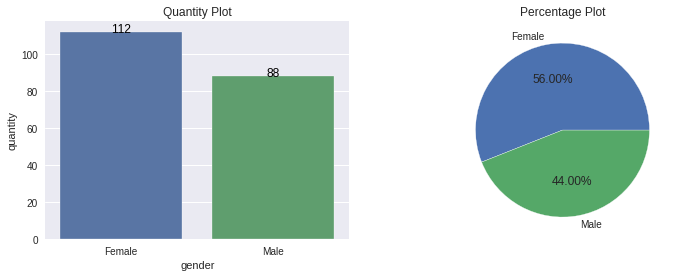

In [8]:
eda_categ_feat_desc_plot(df['gender'])

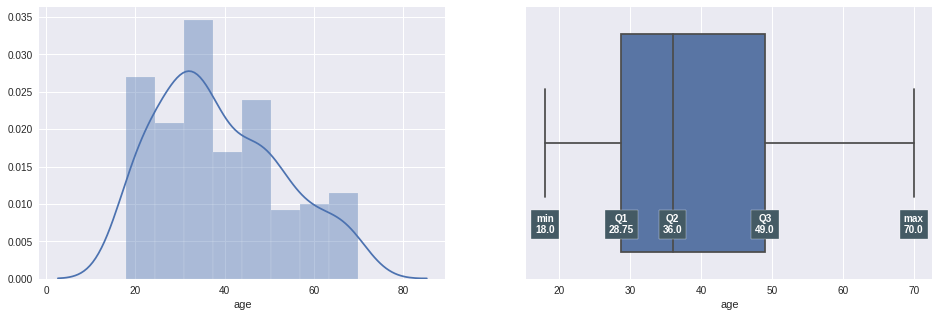

In [9]:
eda_numerical_feat(df['age'])

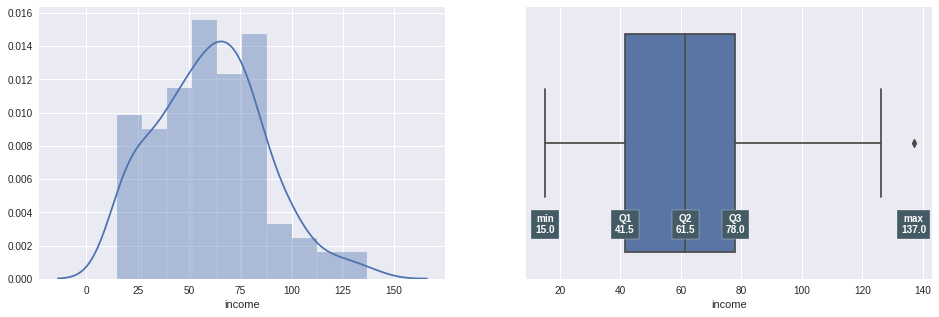

In [10]:
eda_numerical_feat(df['income'])

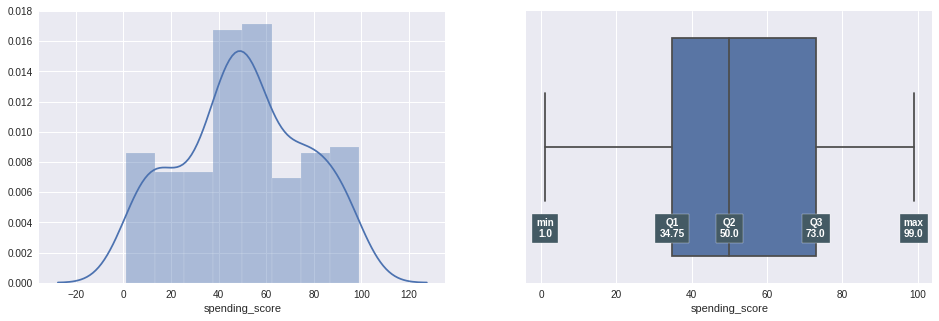

In [11]:
eda_numerical_feat(df['spending_score'])

### Cross two features <a id='index05'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

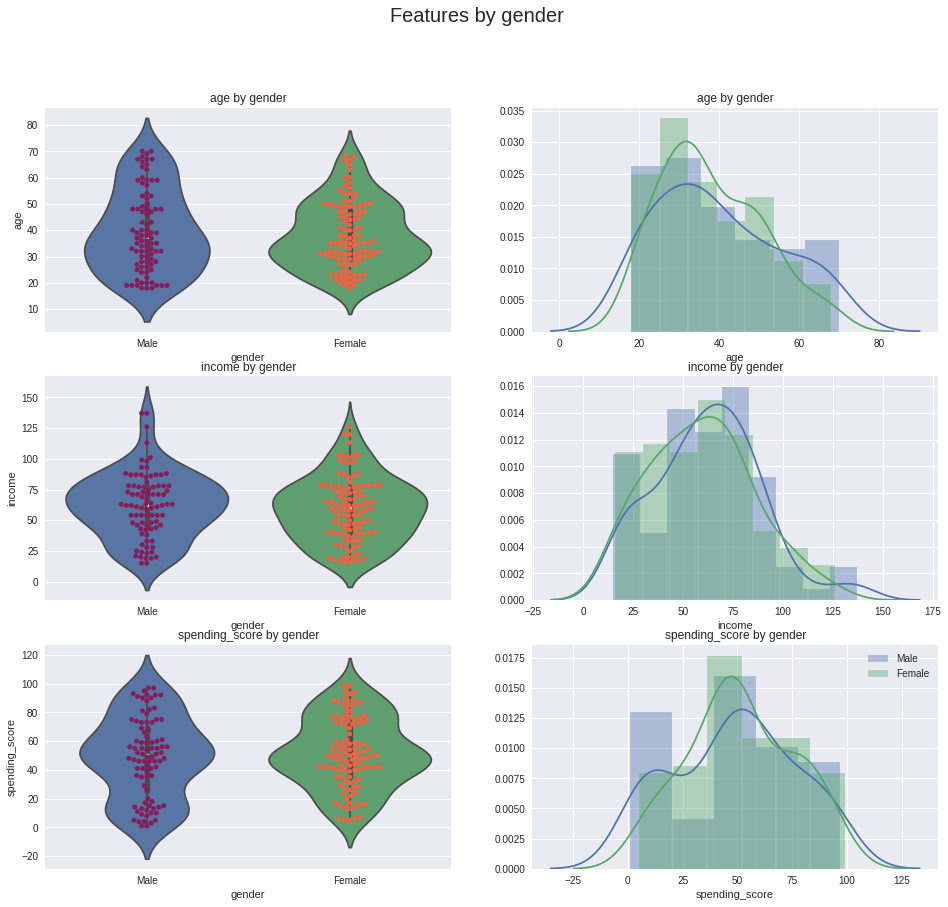

In [12]:
fig, ((ax1, ax2), (ax3,ax4), (ax5, ax6)) = plt.subplots(
    figsize = (16,14), ncols=2, nrows=3, sharex=False, sharey=False)

# age
sns.violinplot(x="gender", y="age", data=df, ax=ax1)
sns.swarmplot(x="gender", y="age", data=df, ax=ax1, palette='rocket')
sns.distplot(df[ df['gender'] == 'Male']['age'], ax=ax2, label="Male")
sns.distplot(df[ df['gender'] == 'Female']['age'], ax=ax2, label="Female")

# income
# sns.boxplot(x="gender", y="income", data=df, ax=ax3)
sns.violinplot(x="gender", y="income", data=df, ax=ax3)
sns.swarmplot(x="gender", y="income", data=df, ax=ax3, palette='rocket')
sns.distplot(df[ df['gender'] == 'Male']['income'], ax=ax4, label="Male")
sns.distplot(df[ df['gender'] == 'Female']['income'], ax=ax4, label="Female")

# spending_score
sns.violinplot(x="gender", y="spending_score", data=df, ax=ax5)
sns.swarmplot(x="gender", y="spending_score", data=df, ax=ax5, palette='rocket')
sns.distplot(df[ df['gender'] == 'Male']['spending_score'], ax=ax6, label="Male")
sns.distplot(df[ df['gender'] == 'Female']['spending_score'], ax=ax6, label="Female")

# Config Titles
fig.suptitle('Features by gender', fontsize=20)
font_size = 16
ax1.set_title('age by gender')
ax2.set_title('age by gender')
ax3.set_title('income by gender')
ax4.set_title('income by gender')
ax5.set_title('spending_score by gender')
ax6.set_title('spending_score by gender')

plt.legend();
plt.show()

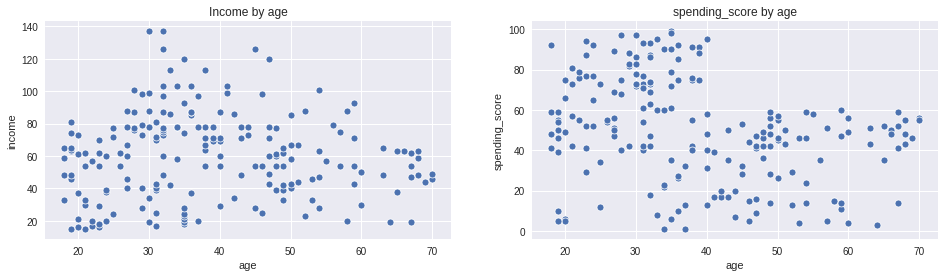

In [13]:
fig, (ax1, ax2) = plt.subplots(figsize = (16,4), ncols=2, sharex=False, sharey=False)

sns.scatterplot(x="age", y="income", data=df, ax=ax1)
sns.scatterplot(x="age", y="spending_score", data=df, ax=ax2)
ax1.set_title("Income by age")
ax2.set_title('spending_score by age')
plt.show()

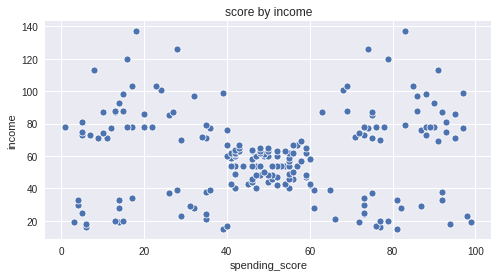

In [14]:
fig, ax1 = plt.subplots(figsize = (8,4))

sns.scatterplot(x="spending_score", y="income", data=df, ax=ax1)
ax1.set_title('score by income')
plt.show()

### Cross all features <a id='index06'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

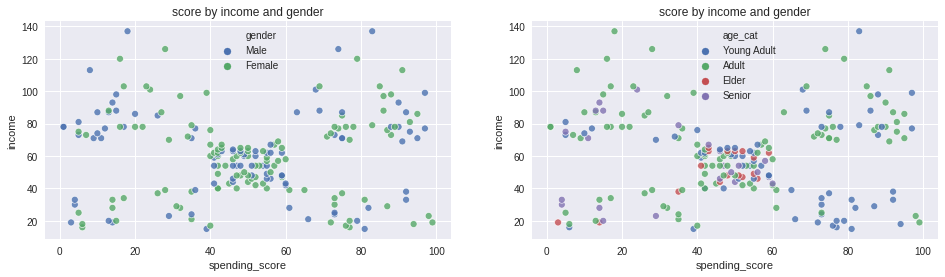

In [15]:
fig, (ax1, ax2) = plt.subplots(figsize = (16,4), ncols=2, sharex=False, sharey=False)

sns.scatterplot(x="spending_score", y="income", hue='gender', data=df, ax=ax1, alpha = 0.8)
ax1.set_title('score by income and gender')

sns.scatterplot(x="spending_score", y="income", hue='age_cat', data=df, ax=ax2, alpha = 0.8)
ax2.set_title('score by income and gender')

plt.show()

## Pre-Processing <a id='index07'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

In [16]:
# Convert Gender to LabelEnconder: 0/1
label_encoder = LabelEncoder()
df_pre_processing = df.drop('age_cat',axis=1)
df_pre_processing['gender'] = label_encoder.fit_transform(df['gender'])

X0 = df_pre_processing.values
X0[0]

array([ 1, 19, 15, 39])

## Clustering with K-Means <a id='index08'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

In [17]:
map_labels = {0: 'g1', 1: 'g2', 2: 'g3', 3: 'g4', 4: 'g5', 5: 'g6', 6: 'g7',
               7: 'g8', 8: 'g9', 9: 'g10', 10: 'g11', 11: 'g12', 12: 'g13'}

In [18]:
df.head()

,gender,age,income,spending_score,age_cat
0,Male,19,15,39,Young Adult
1,Male,21,15,81,Young Adult
2,Female,20,16,6,Young Adult
3,Female,23,16,77,Young Adult
4,Female,31,17,40,Adult


## Best K with elbow method <a id='index09'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>


[Elbow Method of yellowbrick](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html)

the “elbow” method to help data scientists select the optimal number of clusters by fitting the model with a range of values for 𝐾. If the line chart resembles an arm, then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point. In the visualizer “elbow” will be annotated with a dashed line.

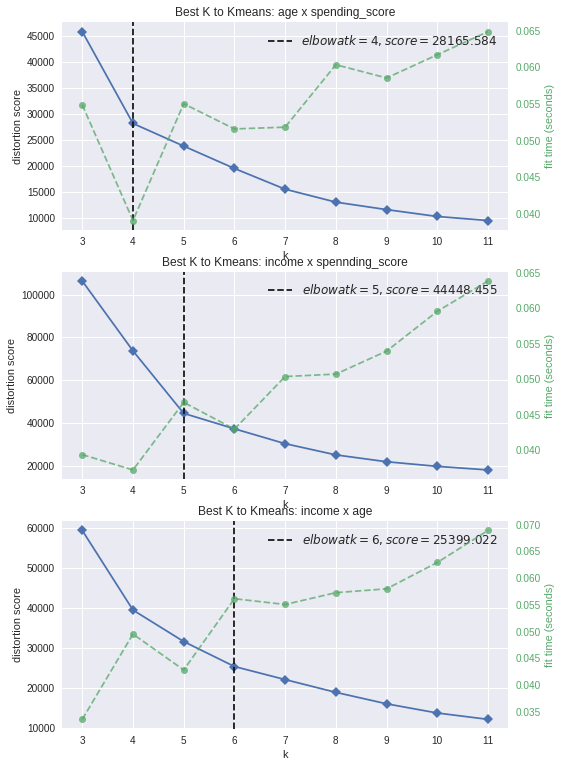

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (8,13), nrows=3, sharex=False, sharey=False)

X1 = df[['age','spending_score']].values
X2 = df[['income','spending_score']].values
X3 = df[['income','age']].values

model = KMeans()

viz1 = KElbowVisualizer(model, k=(3,12), ax=ax1)
viz1.fit(X1)
viz1.finalize()
ax1.set_title('Best K to Kmeans: age x spending_score')

viz2 = KElbowVisualizer(model, k=(3,12), ax=ax2)
viz2.fit(X2)
viz2.finalize()
ax2.set_title('Best K to Kmeans: income x spennding_score')

viz3 = KElbowVisualizer(model, k=(3,12), ax=ax3)
viz3.fit(X3)
viz3.finalize()
ax3.set_title('Best K to Kmeans: income x age')

plt.show()

### Execute KMeans <a id='index10'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

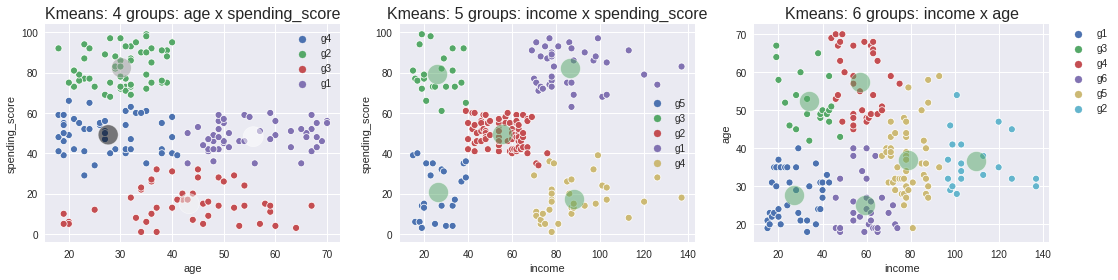

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (18,4), ncols=3)

# K-MEANS-01

X, f1, f2, clusters = X1, 'age', 'spending_score', 4

kmeans = KMeans(n_clusters = clusters ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan')
kmeans.fit(X)
labels, centroids = [map_labels[label_num] for label_num in kmeans.labels_], kmeans.cluster_centers_

sns.scatterplot(x =f1 ,y = f2 , data=df, hue=labels, ax=ax1)
sns.scatterplot(x = centroids[: , 0] , y =  centroids[: , 1] ,
                palette = 'Set2' , alpha = 0.5, s=400, ax=ax1)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # legend outside
ax1.set_title('Kmeans: {} groups: {} x {}'.format(str(clusters), f1, f2), fontsize=16)

# K-MEANS-02

X, f1, f2, clusters = X2, 'income', 'spending_score', 5
kmeans = KMeans(n_clusters = clusters ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan')
kmeans.fit(X)
labels, centroids = [map_labels[label_num] for label_num in kmeans.labels_], kmeans.cluster_centers_

sns.scatterplot(x =f1 ,y = f2 , data=df, hue=labels, ax=ax2)
sns.scatterplot(x = centroids[: , 0] , y =  centroids[: , 1] ,
                palette = 'Set3' , alpha = 0.5, s=400, ax=ax2)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # legend outside
ax2.set_title('Kmeans: {} groups: {} x {}'.format(str(clusters), f1, f2), fontsize=16)

# K-MEANS-03

X, f1, f2, clusters = X3, 'income', 'age', 6
kmeans = KMeans(n_clusters = clusters ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan')
kmeans.fit(X)
labels, centroids = [map_labels[label_num] for label_num in kmeans.labels_], kmeans.cluster_centers_

sns.scatterplot(x =f1 ,y = f2 , data=df, hue=labels, ax=ax3)
sns.scatterplot(x = centroids[: , 0] , y =  centroids[: , 1] ,
                palette = 'Set3' , alpha = 0.5, s=400, ax=ax3)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # legend outside
ax3.set_title('Kmeans: {} groups: {} x {}'.format(str(clusters), f1, f2), fontsize=16)

plt.show()

### Groups Interpreting <a id='index11'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

As Clustering is an unsupervised task, it is necessary to specify each group

Grouping by income and age: 6 groups
+ g1: Customers with income and age between 40
+ g2: Customers with an income above about 95
+ g3: Customers with income between 0 and 45 and age over 40
+ g4: Customers with income between 40 and 70 and age over 45
+ g5: Customers with income between 70 and 85
+ g6: Customers with income between 45 and 75 and age up to 40

Grouping by income and score: 5 groups
+ g1: Customers with income and score above 70
+ g2: Customers with income and scores between 40 and 60
+ g3: Customers with income from 0 to 40 and scores above 60
+ g4: Customers with income above 70 and score up to 40
+ g5: Customers with income from 0 to 40 and score from 0 to 40

Grouping by age and score: 4 groups
+ g1: Customers over 45 and with a score between 40 and 60
+ g2: Customers under 45 years old and with scores between 40 and 60
+ g3: Customers with scores between 0 and 35
+ g4: Customers aged between 20 and 40 and scores between 70 and 100

## Clustering by pycaret <a id='index13'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

http://www.pycaret.org/tutorials/html/CLU101.html


In [21]:
!pip install pycaret
from pycaret.clustering import *

     |████████████████████████████████| 252 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 258 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 13.9 MB 431 kB/s eta 0:00:01
     |████████████████████████████████| 96 kB 4.3 MB/s  eta 0:00:01
     |████████████████████████████████| 64 kB 2.1 MB/s  eta 0:00:01
     |████████████████████████████████| 3.1 MB 52.1 MB/s eta 0:00:01
     |████████████████████████████████| 326 kB 48.8 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 4.1 MB/s  eta 0:00:01


     |████████████████████████████████| 1.1 MB 64.9 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 4.0 MB/s  eta 0:00:01
     |████████████████████████████████| 6.0 MB 44.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 41.5 MB/s eta 0:00:01
     |████████████████████████████████| 121 kB 48.8 MB/s eta 0:00:01
     |████████████████████████████████| 84 kB 2.4 MB/s  eta 0:00:01


     |████████████████████████████████| 45 kB 2.1 MB/s  eta 0:00:01
  Created wheel for pyod: filename=pyod-0.8.3-py3-none-any.whl size=110347 sha256=c7076b91c21e7eff869c83d23f6bf1d87b738964face2981f6dd2716dac18700
  Stored in directory: /root/.cache/pip/wheels/fc/fc/77/6e530134c9ee2b45ef0840f0c8046b3be595624881cf533d7a
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158154 sha256=2fab2219d8b2fe7298fa56b6cfe65dfc0fb28b17ff97df84f4dbbd49e12a6428
  Stored in directory: /root/.cache/pip/wheels/be/5d/0a/9e13f53f4f5dfb67cd8d245bb7cdffe12f135846f491a283e3
  Created wheel for databricks-cli: filename=databricks_cli-0.11.0-py3-none-any.whl size=90300 sha256=e204e4d58d59b3d84b61d0c4397cfc8349fe963008fba06a431c96213dc2f5fe
  Stored in directory: /root/.cache/pip/wheels/81/3f/18/5678c9d403583e583a251463196998b17852b98de34aa9ab51
  Created wheel for querystring-parser: filename=querystring_parser-1.2.4-py3-none-any.whl size=7076 sha256=a20489cfb45aa74e89477234366cd62a

      Successfully uninstalled tangled-up-in-unicode-0.0.4
  Attempting uninstall: visions
    Found existing installation: visions 0.4.1
    Uninstalling visions-0.4.1:
      Successfully uninstalled visions-0.4.1
  Attempting uninstall: pandas-profiling
    Found existing installation: pandas-profiling 2.6.0
    Uninstalling pandas-profiling-2.6.0:
      Successfully uninstalled pandas-profiling-2.6.0
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 1.3.16
    Uninstalling SQLAlchemy-1.3.16:
      Successfully uninstalled SQLAlchemy-1.3.16
  Attempting uninstall: alembic
    Found existing installation: alembic 1.4.2
    Uninstalling alembic-1.4.2:
      Successfully uninstalled alembic-1.4.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver bef

In [23]:
df.head()

,gender,age,income,spending_score,age_cat
0,Male,19,15,39,Young Adult
1,Male,21,15,81,Young Adult
2,Female,20,16,6,Young Adult
3,Female,23,16,77,Young Adult
4,Female,31,17,40,Adult


In [25]:
pycaret_cluster_setup = setup(df, normalize = True,
                              categorical_features = ['gender'],
                              ignore_features = ['age_cat'],
                              session_id = 42)

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Original Data,"(200, 5)"
2,Missing Values,False
3,Numeric Features,2
4,Categorical Features,3
5,Ordinal Features,False
6,High Cardinality Features,False
7,Transformed Data,"(200, 5)"
8,Numeric Imputer,mean
9,Categorical Imputer,constant


In [26]:
kmeans = create_model('kmeans')

,Metric
Silhouette,0.320
Calinski-Harabasz,85.148
Davies-Bouldin,1.179


In [27]:
kmean_results = assign_model(kmeans)
kmean_results.head()

,gender,age,income,spending_score,age_cat,Cluster
0,Male,19,15,39,Young Adult,Cluster 0
1,Male,21,15,81,Young Adult,Cluster 0
2,Female,20,16,6,Young Adult,Cluster 0
3,Female,23,16,77,Young Adult,Cluster 0
4,Female,31,17,40,Adult,Cluster 0


In [44]:
plot_model(kmeans)

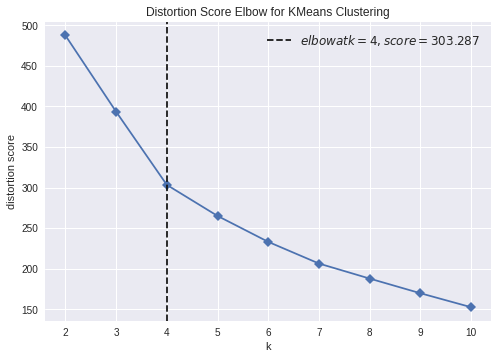

In [29]:
plot_model(kmeans, plot = 'elbow')

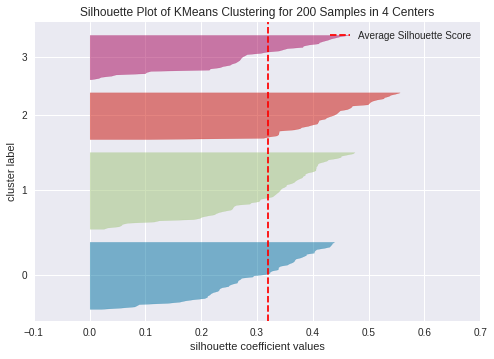

In [30]:
plot_model(kmeans, plot = 'silhouette')

In [31]:
plot_model(kmeans, plot = 'distribution') #to see size of clusters

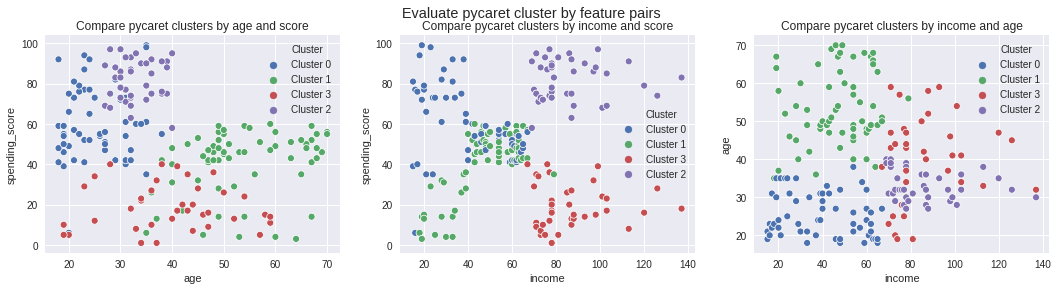

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (18,4), ncols=3)
fig.suptitle('Evaluate pycaret cluster by feature pairs')

sns.scatterplot(data=kmean_results, x="age", y="spending_score", hue="Cluster", ax=ax1)
ax1.set_title('Compare pycaret clusters by age and score')

sns.scatterplot(data=kmean_results, x="income", y="spending_score", hue="Cluster", ax=ax2)
ax2.set_title('Compare pycaret clusters by income and score')

sns.scatterplot(data=kmean_results, x="income", y="age", hue="Cluster", ax=ax3)
ax3.set_title('Compare pycaret clusters by income and age')

plt.show()

The pycaret clusters were made using PCA a dimensionality reduction technique, reducing the 3 numerical variables to two (PCA1, PCA2).

Comparing with the previous Kmeans models, this technique obtained a good result since, when evaluating each pair of numerical features, we can see that it grouped well with a little mixture (which is evident to be seen since in the elbows tests for each pair, identified the best k as 4 or higher).

Finally, the clusters made by pycaret are good choices, since reducing to PCA1 and PCA2 was able to separate each customer well.

<!-- 
Os clusters do pycaret foram feito usando PCA uma técnica de reduçâo de dimensionalidade, reduzindo as 3 variáveis númerias para duas (PCA1, PCA2).

Comparando com os modelos de Kmeans anteior, essa técnica obteve bom resultado já que ao avaliar cada par de features numéricas, podemos ver que agrupou bem com umpouco de mistura (o que é evidente de se constatar já que nos testes de elbows para cada par, identificava o melhor k como 4 ou maior).

Por fim, os clusters feito pelo pycaret são boas escolhas, já que ao reduzir para PCA1e PCA2 foi capaz de separar bem cada customer.
-->

## Conclusion <a id='index12'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

Three groupings were made using the k-means algorithm each using two features.

This is my first grouping kernel, tips and ideas for enhancing are welcome.